In [42]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import joblib

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

## --- Finding the optimal number of cluster

In [43]:
# pca was added just to calculate bic and silhouette-score, but because it was worse than manually generated features it wont be used in further steps
X_pca = np.load("X_pca.npy")
pca = joblib.load("pca_model.joblib")
data_final = pd.read_csv("data_final.csv")

In [44]:
### calculate bic and aic
n_components_range = range(2, 13)

bics = []
aics = []

for n in n_components_range:
    gmm = GaussianMixture(
        n_components=n,
        covariance_type='full',
        random_state=42
    )
    gmm.fit(data_final)
    bics.append(gmm.bic(data_final))
    aics.append(gmm.aic(data_final))


C:\Users\dawid\anaconda3\envs\health_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\dawid\anaconda3\envs\health_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\dawid\anaconda3\envs\health_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\dawid\anaconda3\envs\health_analysis\Lib\site-packages\sklearn\c

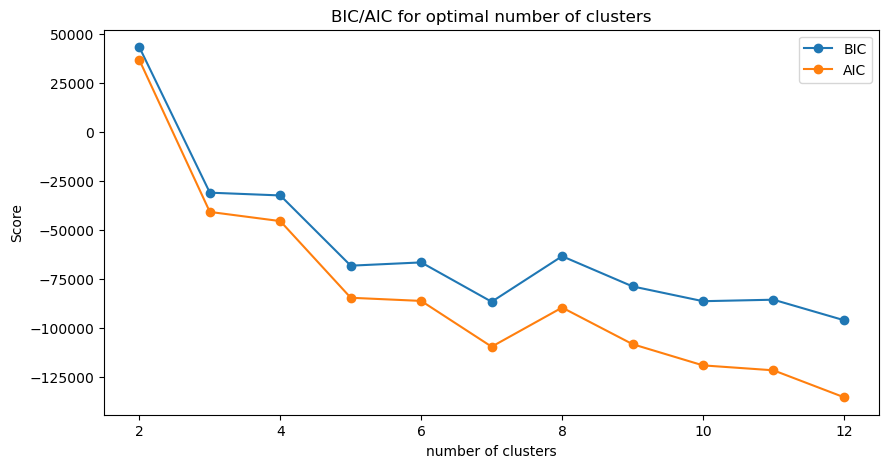

In [45]:
plt.figure(figsize=(10, 5))
plt.plot(n_components_range, bics, label='BIC', marker='o')
plt.plot(n_components_range, aics, label='AIC', marker='o')
plt.xlabel("number of clusters")
plt.ylabel("Score")
plt.title("BIC/AIC for optimal number of clusters")
plt.legend()
plt.savefig("bic_man_gen.png", dpi=300, bbox_inches="tight")
plt.show()

In [46]:
from sklearn.metrics import silhouette_score

### calculate silhouette score for GMM with multiple number of clusters
def silhouette_for_gmm(X, k_values, covariance_type="full"):
    scores = {}

    for k in k_values:
        gmm = GaussianMixture(n_components=k, covariance_type=covariance_type, random_state=0)
        labels = gmm.fit_predict(X)

        if len(np.unique(labels)) > 1:
            score = silhouette_score(X, labels)
        else:
            score = -1  # silhouette-score not defined if k=1

        scores[k] = score
        print(f"k = {k}, Silhouette Score = {score:.4f}")

    return scores


k_values = range(2, 11)
scores = silhouette_for_gmm(data_final, k_values)



C:\Users\dawid\anaconda3\envs\health_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\dawid\anaconda3\envs\health_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\dawid\anaconda3\envs\health_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\dawid\anaconda3\envs\health_analysis\Lib\site-packages\sklearn\c

k = 2, Silhouette Score = 0.2951
k = 3, Silhouette Score = 0.2784
k = 4, Silhouette Score = 0.1305
k = 5, Silhouette Score = 0.1422
k = 6, Silhouette Score = 0.0936
k = 7, Silhouette Score = 0.0919
k = 8, Silhouette Score = 0.0878


C:\Users\dawid\anaconda3\envs\health_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\dawid\anaconda3\envs\health_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\dawid\anaconda3\envs\health_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


k = 9, Silhouette Score = 0.0880
k = 10, Silhouette Score = 0.1081


C:\Users\dawid\anaconda3\envs\health_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
